In [1]:
# Imports...
import os.path
from os import makedirs
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

# Classical ML.
import torch
from torch import manual_seed
from torch.utils.data import DataLoader

# Quantum ML.
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN

# Version control.
from qiskit import __version__ as qiskit_version
from qiskit_machine_learning import __version__ as qml_version
from qiskit_algorithms import __version__ as alg_version
from torch import __version__ as torch_version

# Plotting.
import matplotlib.pyplot as plt
import seaborn as sns

# Scripts.
from scripts.utils import sample_n_states
from scripts.circuits import build_circuit
from scripts.learning import build_qnn_circuit, train_by_scipy, train_by_COBYLA_no_recylcing, train_by_torch

# Additional imports.
from scipy.optimize import curve_fit, least_squares

# Styling.
sns.set_context('paper')
sns.set_theme(style='darkgrid', palette='Dark2')

# Device management.
if torch.cuda.is_available(): device = torch.device('cuda')
else: device = torch.device('cpu')

# Random seed setting.
def set_seed(seed):
    if seed is None: return
    
    algorithm_globals.random_seed = seed
    np.random.seed(seed)
    manual_seed(seed)
    
set_seed(42)

# Package versions (ignoring packages that obviously won't be a problem).
print('Important Package Versions...\n')
versions = [('qiskit', qiskit_version), ('qiskit_machine_learning', qml_version), ('qiskit_algorithms', alg_version), ('numpy', np.__version__), ('torch', torch_version)]

pad = max([len(x) for x, _ in versions])
for package, version in versions:
    print(f'{package:<{pad}} : {version}')

Important Package Versions...

qiskit                  : 1.1.1
qiskit_machine_learning : 0.7.2
qiskit_algorithms       : 0.3.0
numpy                   : 1.24.3
torch                   : 2.3.1


# Learning by Width

This notebook concerns itself with understanding performance with respect to the number of qubits. It is also concerned with the estimated number of samples and queries to the unitary.

## Queries

In [3]:
# For reference, the below took ~21.3 hours.

# Hyperparameters.
ns = [3, 4, 5]
ds = [5, 15, 25]
n_U = 3
target_qubits = [1, 2]
ansatz_reps = 4
max_epochs = 3000
zero_threshold = 5e-2
early_stop_window = 250
early_stop_threshold = 1e-3
tol = None

# Save path.
save_path = './data/performance-by-width-early-stop.csv'

# Ensure the directory to the save path exists.
makedirs(os.path.dirname(save_path), exist_ok=True)

# If the save file does not already exist, create it with the appropriate headers.
if not os.path.exists(save_path): pd.DataFrame(columns=['id', 'Train Loss', 'Val Loss', 'U Depth', 'No. Qubits', 'No. Samples', 'Ansatz Depth', 'Mean Epoch Runtime', 'Epochs']).set_index('id').to_csv(save_path)

for n in tqdm(ns, desc='Top level'):
    # Common validation set.
    xs_val = sample_n_states(n_states=64, n_qubits=n, seed=None)
    
    for d in ds:
        for n_samples in (2 ** i for i in range(n + 1)):
            # Train set.
            xs_train = sample_n_states(n_states=n_samples, n_qubits=n, seed=None)
            
            for _ in tqdm(range(n_U), desc='Bottom level',leave=False):
                # Generate a random unitary.
                U = build_circuit(n=n, d=d, seed=None)
                
                # Build a circuit for the QNN from U.
                qnn_circuit, input_parameters, weight_parameters = build_qnn_circuit(U, ansatz_reps=ansatz_reps, target_qubits=target_qubits, multi_swap=True)
                
                # Define a QNN object. 
                qnn = SamplerQNN(
                    circuit=qnn_circuit,
                    input_params=input_parameters,
                    weight_params=weight_parameters,
                    interpret=lambda x: x,
                    output_shape=2 ** len(target_qubits), # Multi-qubit SWAP test outputs.
                    input_gradients=True
                )
                
                # Explicitly declare initial weights (else they will be uniformly randomly sampled from [-1, 1]).
                initial_weights = .1 * (2 * algorithm_globals.random.random(qnn.num_weights) - 1)
                
                # Train the QNN.
                stats = train_by_scipy(qnn, xs_train, xs_val, max_epochs, initial_weights, method='cobyla', zero_threshold=zero_threshold, early_stop_window=early_stop_window, early_stop_threshold=early_stop_threshold, early_stop_on_train=True, tol=tol, seed=None, live_plot=False)
                
                # Write the stats to the save path.
                pd.DataFrame({
                    'Train Loss': [np.min(stats['train_loss'])], 
                    'Val Loss': [np.min(stats['val_loss'])], 
                    'U Depth': [d], 
                    'No. Qubits': [n], 
                    'No. Samples' : [n_samples],
                    'Ansatz Depth': [ansatz_reps], 
                    'Mean Epoch Runtime': [np.mean(stats['runtime'])], 
                    'Epochs': [len(stats['train_loss'])]
                }).to_csv(save_path, mode='a', header=False)

Top level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

Bottom level:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
# Read in data.
data = pd.read_csv('./data/performance-by-width-early-stop.csv').set_index('id').reset_index(drop=True)

# Any losses below the threshold (.05 here) can be said to be convergent on 0.
data['Val Loss'] = data['Val Loss'].apply(lambda x: 0 if x < 0.05 else x) 
data['Train Loss'] = data['Train Loss'].apply(lambda x: 0 if x < 0.05 else x) 
data

,Train Loss,Val Loss,U Depth,No. Qubits,No. Samples,Ansatz Depth,Mean Epoch Runtime,Epochs
0,0.000000,0.351082,5,3,1,4,0.307640,290
1,0.000000,0.318881,5,3,1,4,0.297283,290
2,0.000000,0.346911,5,3,1,4,0.297781,261
3,0.000000,0.331450,5,3,2,4,0.300437,315
4,0.000000,0.410252,5,3,2,4,0.300854,284
...,...,...,...,...,...,...,...,...
129,0.119415,0.183151,25,5,16,4,1.043202,2438
130,0.210859,0.280683,25,5,16,4,1.044225,961
131,0.188455,0.242897,25,5,16,4,1.043311,1696
132,0.228749,0.279207,25,5,32,4,1.351756,1012


<Axes: xlabel='No. Samples', ylabel='Val Loss'>

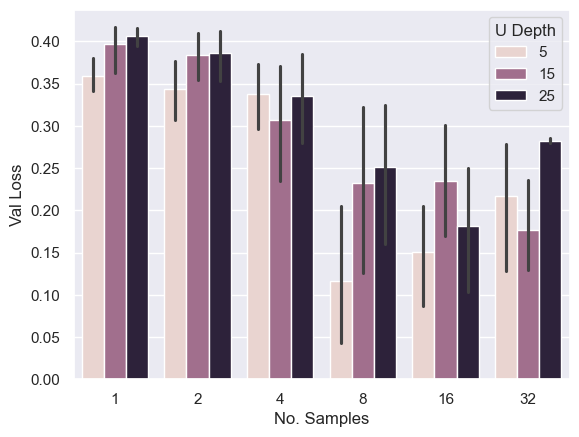

In [6]:
sns.barplot(data=data, x='No. Samples', y='Val Loss', hue='U Depth')

<Axes: xlabel='No. Samples', ylabel='Val Loss'>

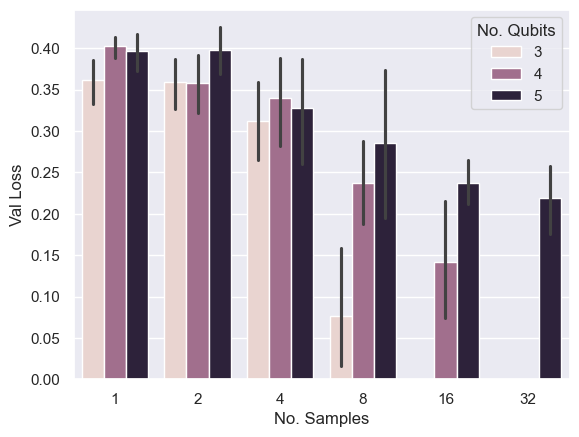

In [7]:
sns.barplot(data=data, x='No. Samples', y='Val Loss', hue='No. Qubits')